<a href="https://colab.research.google.com/github/ahmedlabib02/Nlp-project/blob/main/Nlp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone 1

In [5]:
# %pip install transformers
# %pip install nltk
# %pip install farasapy
# %pip install --quiet camel-tools-data
# %pip install camel-tools
# %pip install camel-tools -f https://download.pytorch.org/whl/torch_stable.html


%pip install --upgrade -f https://download.pytorch.org/whl/torch_stable.html camel-tools

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached camel_tools-1.5.5-py3-none-any.whl (124 kB)
  Using cached transformers-4.43.4-py3-none-any.whl (9.4 MB)
  Using cached muddler-0.1.3-py3-none-any.whl (16 kB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.49.0
    Uninstalling transformers-4.49.0:
      Successfully uninstalled transformers-4.49.0
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\sana2\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [ ]:
import os 
import json
import re
import pandas as pd
from collections import Counter
import string
from transformers import BertTokenizer
import nltk
import numpy as np
from nltk.corpus import stopwords
from farasa.segmenter import FarasaSegmenter
from nltk.stem.isri import ISRIStemmer
from camel_tools.morphology.database import MorphologyDB
from camel_tools.morphology.analyzer import Analyzer
from nltk.stem.isri import ISRIStemmer
segmenter = FarasaSegmenter(interactive=False)
nltk.download('stopwords')




c:\Users\sana2\AppData\Local\Programs\Python\Python39\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


 50%|████▉     | 119M/241M [05:59<10:51, 187kiB/s] 

### Data preparation

#### Unzipping the "B Hodoo2" channel folder

In [25]:
import zipfile
zip_path = "./B Hodoo2-20250226T182935Z-001.zip"
extract_path = "./"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


#### Unzipping the "Kefaya ba2a" channel folder

In [26]:
import zipfile
zip_path = "./Kefaya Ba2a-20250226T183527Z-001.zip"
extract_path = "./"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

### Building dict for annotations and text

In [2]:
def standardize(title):
    
    title = title.replace("_", " ")
   
    title = title.lower()
    
    title = re.sub(r'[^\w\s]', '', title)
    
    # title = re.sub(r'\bبودكاست بهدوء مع كريم\b', '', title)
    # title = re.sub(r'\bجلسة\b', '', title)
    
    title = re.sub(r'\s+', ' ', title).strip()
    return title

In [3]:
def get_category_for_filename(target_filename, annotations_path):
    """
    Load annotations from annotations_path and try to match the
    canonicalized target_filename (without file extension) to the canonicalized
    title from each annotation. If a match is found, return the annotation's category.
    """
    with open(annotations_path, 'r', encoding='utf-8') as f_json:
        annotations = json.load(f_json)
    
    base_target = os.path.splitext(target_filename)[0]
    target_can = standardize(base_target)
    for entry in annotations:
        annotation_title = entry.get('title')
        if annotation_title:
            
            annotation_can = standardize(annotation_title)
            if annotation_can == target_can:
                # print("Matched annotation:", entry.get('title'))
                return entry.get('category')
    return None

In [4]:
def add_transcripts_from_folder(transcripts_dict, folder_path, channel):
    
    annotations_json = os.path.join(folder_path, 'annotations.json')
    raw_folder = os.path.join(folder_path, 'raw')
    for filename in os.listdir(raw_folder):
        full_path = os.path.join(raw_folder, filename)
        if os.path.isfile(full_path):
            with open(full_path, 'r', encoding='utf-8') as file:
                transcript = file.read()
                category = get_category_for_filename(filename, annotations_json)
            base_filename, _ = os.path.splitext(filename)
            transcripts_dict[base_filename] = (channel, category, transcript)
    return transcripts_dict

In [18]:
transcripts_dict = {}
first_folder_path = './B Hodoo2/'
second_folder_path = './Kefaya Ba2a/'

transcripts_dict = add_transcripts_from_folder(transcripts_dict, first_folder_path,  'B Hodoo2')
transcripts_dict = add_transcripts_from_folder(transcripts_dict, second_folder_path, 'Kefaya Ba2a')



### Creating a dataframe

In [19]:
data = [(title, info[0], info[1], info[2]) for title, info in transcripts_dict.items()]
df = pd.DataFrame(data, columns=['title', 'channel', 'category', 'transcript'])
print(df.head())


                                               title   channel   category  \
0  أكبر كذبة في التاريخ _ وهم الانتاجية! - _ بودك...  B Hodoo2  Education   
1  إزاي ضاعفت دخلي بدون شغل إضافي! - عن الرزق ووس...  B Hodoo2  Education   
2  اخطر محتوى في العالم! _ بودكاست بهدوء مع كريم ...  B Hodoo2  Education   
3  العيد والنكد - ليه مش بنبسط في العيد؟ _ بودكاس...  B Hodoo2  Education   
4  انا فقير _ اصحابي كلهم أغنى مني! _ بودكاست بهد...  B Hodoo2  Education   

                                          transcript  
0  النهارده الفيديو بتاعنا على\nالانتاجيه لان الن...  
1  انا النهارده جاي اقوللك ازاي تزود من\nدخلك الم...  
2  النهارده انا جاي اتكلم على واحده من اخطر\nالظو...  
3  بصراحه انا موضوع ان احنا مش عارفين نتبسط\nفي ا...  
4  مساء الفل الفيديو ده عن الرزق لو انت\nواحد من ...  


### Before pre-processing analysis

**Reveals the number of rows and columns, data types of each column, and non-null counts.**

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       48 non-null     object
 1   channel     48 non-null     object
 2   category    47 non-null     object
 3   transcript  48 non-null     object
dtypes: object(4)
memory usage: 1.6+ KB


**Identifying which columns have missing values**

In [21]:
print(df.isnull().sum())

title         0
channel       0
category      1
transcript    0
dtype: int64


**Since there are some entries without categories or an annotation file, we just remove them.**

In [22]:
df = df[df['category'].notna()]

**Measuring number of transcript and exploring outliers**

In [25]:
df['raw_length'] = df['transcript'].apply(len)
print(df['raw_length'].describe())

count       47.000000
mean     21778.021277
std       9970.770825
min        930.000000
25%      17160.500000
50%      20942.000000
75%      25980.500000
max      51920.000000
Name: raw_length, dtype: float64


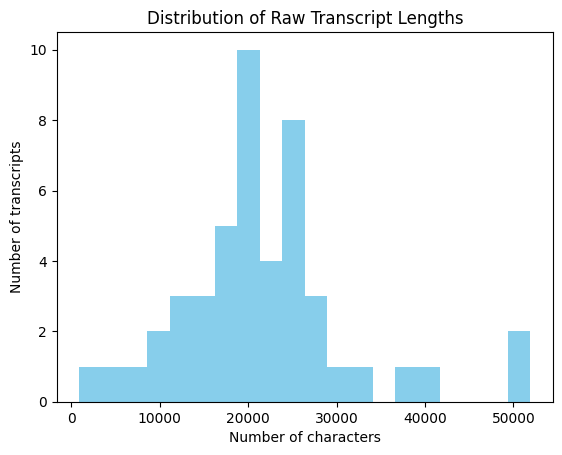

In [26]:
import matplotlib.pyplot as plt

plt.hist(df['raw_length'], bins=20, color='skyblue')
plt.xlabel("Number of characters")
plt.ylabel("Number of transcripts")
plt.title("Distribution of Raw Transcript Lengths")
plt.show()

category
Education         26
People & Blogs    17
Comedy             4
Name: count, dtype: int64


<Axes: title={'center': 'Category Distribution'}, xlabel='category'>

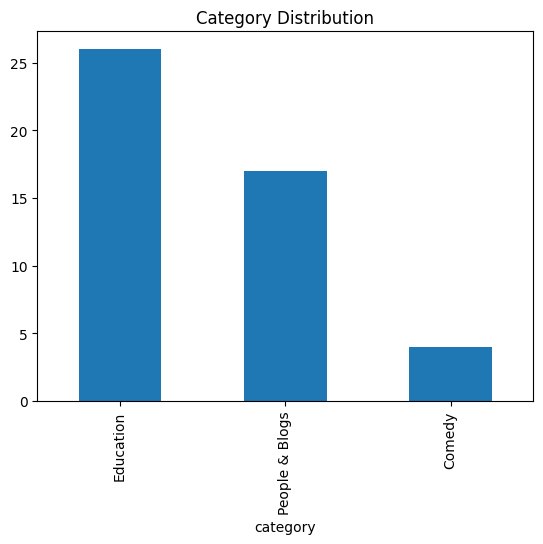

In [10]:
print(df['category'].value_counts())
df['category'].value_counts().plot(kind='bar', title='Category Distribution')

In [27]:
print(df['channel'].unique())
print(df['channel'].value_counts())

['B Hodoo2' 'Kefaya Ba2a']
channel
B Hodoo2       26
Kefaya Ba2a    21
Name: count, dtype: int64


**Viewing most common words before preprocessing**

In [ ]:
all_text = " ".join(df['transcript'])
words = all_text.split()
word_freq = Counter(words)
print("Top 10 most common words in raw transcripts:")
print(word_freq.most_common(10))

Top 10 most common words in raw transcripts:
[('في', 5726), ('انا', 3823), ('ما', 3330), ('اللي', 3253), ('ده', 2993), ('انت', 2853), ('من', 2737), ('ان', 2699), ('هو', 2628), ('يعني', 2494)]


**Viewing the most common words per category**

In [34]:
def top_words_for_category(cat, n=10):
    subset = df[df['category'] == cat]
    combined_text = " ".join(subset['transcript'])
    words = combined_text.split()
    word_counts = Counter(words)
    return word_counts.most_common(n)
categories = df['category'].unique()
for cat in categories:
    print(f"Category: {cat}")
    top_words = top_words_for_category(cat, n=5)
    for word, count in top_words:
        print(f"  {word}: {count}")

Category: Education
  في: 3018
  انا: 2115
  اللي: 1838
  ان: 1789
  من: 1780
Category: People & Blogs
  في: 2135
  انت: 1332
  انا: 1327
  ما: 1285
  هو: 1259
Category: Comedy
  في: 573
  ما: 399
  يا: 391
  انا: 381
  انت: 364


### Cleaning the data

#### Removing numbers, non-Arabic letters and extra spaces

In [35]:
def clean_text(text):
    punctuations = string.punctuation + "؟،؛«»…ـ"  
    translator = str.maketrans('', '', punctuations)
    text = text.translate(translator)  
    text = re.sub(r'[0-9A-Za-z]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [36]:
df["clean_transcript"] = df["transcript"].apply(clean_text)
print(df.head())

                                               title   channel   category  \
0  أكبر كذبة في التاريخ _ وهم الانتاجية! - _ بودك...  B Hodoo2  Education   
1  إزاي ضاعفت دخلي بدون شغل إضافي! - عن الرزق ووس...  B Hodoo2  Education   
2  اخطر محتوى في العالم! _ بودكاست بهدوء مع كريم ...  B Hodoo2  Education   
3  العيد والنكد - ليه مش بنبسط في العيد؟ _ بودكاس...  B Hodoo2  Education   
4  انا فقير _ اصحابي كلهم أغنى مني! _ بودكاست بهد...  B Hodoo2  Education   

                                          transcript  raw_length  \
0  النهارده الفيديو بتاعنا على\nالانتاجيه لان الن...       21032   
1  انا النهارده جاي اقوللك ازاي تزود من\nدخلك الم...       18261   
2  النهارده انا جاي اتكلم على واحده من اخطر\nالظو...       18546   
3  بصراحه انا موضوع ان احنا مش عارفين نتبسط\nفي ا...       23874   
4  مساء الفل الفيديو ده عن الرزق لو انت\nواحد من ...       11462   

                                    clean_transcript  
0  النهارده الفيديو بتاعنا على الانتاجيه لان النه...  
1  انا النهارده جا

### Tokenization 

In [38]:
def bert_tokenize(df):
    tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
    df['bert_tokens'] = df['clean_transcript'].apply(lambda x: tokenizer.tokenize(str(x)))
bert_tokenize(df)
print(df.head())

                                               title   channel   category  \
0  أكبر كذبة في التاريخ _ وهم الانتاجية! - _ بودك...  B Hodoo2  Education   
1  إزاي ضاعفت دخلي بدون شغل إضافي! - عن الرزق ووس...  B Hodoo2  Education   
2  اخطر محتوى في العالم! _ بودكاست بهدوء مع كريم ...  B Hodoo2  Education   
3  العيد والنكد - ليه مش بنبسط في العيد؟ _ بودكاس...  B Hodoo2  Education   
4  انا فقير _ اصحابي كلهم أغنى مني! _ بودكاست بهد...  B Hodoo2  Education   

                                          transcript  raw_length  \
0  النهارده الفيديو بتاعنا على\nالانتاجيه لان الن...       21032   
1  انا النهارده جاي اقوللك ازاي تزود من\nدخلك الم...       18261   
2  النهارده انا جاي اتكلم على واحده من اخطر\nالظو...       18546   
3  بصراحه انا موضوع ان احنا مش عارفين نتبسط\nفي ا...       23874   
4  مساء الفل الفيديو ده عن الرزق لو انت\nواحد من ...       11462   

                                    clean_transcript  \
0  النهارده الفيديو بتاعنا على الانتاجيه لان النه...   
1  انا النهارده 

**We will use more dialect specific tokenizers using libraries like Camel**

In [39]:
def farasa_tokenize(text):
    text = str(text)
    segmented_text = segmenter.segment(text)
    tokens = segmented_text.split()
    return tokens

df['farasa_tokens'] = df['transcript'].apply(farasa_tokenize)
df['farasa_tokens'] 

0     [النهارده, ال+فيديو, بتاع+نا, على, ال+انتاجيه,...
1     [أنا, النهارده, جاي, اقوللك, ازاي, تزود, من, د...
2     [النهارده, أنا, جاي, اتكلم, على, واحد+ه, من, أ...
3     [ب+صراح+ه, أنا, موضوع, ان, اح+نا, مش, عارف+ين,...
4     [مساء, ال+فل, ال+فيديو, ده, عن, ال+رزق, لو, أن...
6     [عند+نا, في, مصر, ل+ما, ب+يبقى, في, حد, ال+دني...
7     [مافيش, حد, في+نا, الا, و+في, حيا+ت+ه, نسب+ه, ...
8     [يدخل, ال+بيت, فبيقول, ل+ها, و+صف+ي, لي, ال+حر...
9     [النهارده, أنا, جاي, اكلم+ك, في, موضوع, في, من...
10    [ال+حلقه, دي, بقى, ب+ال+ذات, أنا, دائم+ا, يا, ...
11    [من, حوالي, سبع, سن+ين, واحد+ه, كتب+ت, لي, في,...
12    [ال+سلام, علي+كم, و+رحم+ه, أنت, ازاي, تدخل, عل...
13    [أول, يا, جماع+ه, ل+ما, ب+تقول, الله, هو, من, ...
14    [طبع+ا, ك+ال+عاده, اح+نا, اتعودنا, ان, اي, فيد...
15    [النهارده, أنا, ب+هدي, ال+حلقه, دي, ل+نفس+ي, أ...
16    [ينفع, اشارككم, حاج+ه, ب+دون, مثالي+ه, عاليه, ...
17    [وكالعاده, مستمر+ين, في, ال+تمرد, على, ال+غوري...
18    [اهل+ا, و+سهل+ا, ب+كم, في, ال+جزء, ال+تاني

### Stop word removal

**Analysing the stop word removal in each in transcript**

In [40]:
arabic_stopwords = set(stopwords.words('arabic'))

In [41]:
def count_stopwords(tokens, stopwords_set):
    return sum(1 for token in tokens if token in stopwords_set)

In [42]:
# df['stopword_count'] = df['farasa_tokens'].apply(lambda tokens: count_stopwords(tokens, arabic_stopwords))
df['total_tokens'] = df['farasa_tokens'].apply(len)

# print(df[['stopword_count', 'total_tokens']].head())

**Removing the stop words**

In [43]:
def remove_stopwords(tokens, stopwords_set):
    return [token for token in tokens if token not in stopwords_set]

In [44]:
df['tokens_no_stop'] = df['farasa_tokens'].apply(lambda tokens: remove_stopwords(tokens, arabic_stopwords))
df['total_tokens_no_stop'] = df['tokens_no_stop'].apply(len)
print(df[['total_tokens', 'total_tokens_no_stop']].head())

   total_tokens  total_tokens_no_stop
0          4192                  3341
1          3652                  2995
2          3532                  2895
3          4657                  3776
4          2308                  1842


### Removing custom egyptian stop words


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(use_idf=True)
tfidf_matrix = vectorizer.fit_transform(df['farasa_tokens'])
idf = vectorizer.idf_
terms = vectorizer.get_feature_names_out()

term_idf = list(zip(terms, idf))
common_words = [term for term, score in term_idf if score < np.percentile(idf, 10)]
print("Candidate stopwords based on low IDF:", common_words)


In [ ]:
egyptian_stopwords = {
    "بلاش",  
    "ايه",  
    "يعني",  
    "أوي",  
    "اللي",
    "ان",
    "ده" , 
      "مش",
      "دي",
      "بقى",
      "كده",
      "مالوش",
      "بس",
      
      
      
    
    # add more Egyptian dialect stop words here
}

### Stemming and Lemmatization

**Stemming**

In [45]:
stemmer = ISRIStemmer()
df['stemmed_tokens'] = df['tokens_no_stop'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])
df['tokens_no_stop'].head()

0    [النهارده, ال+فيديو, بتاع+نا, ال+انتاجيه, لان,...
1    [النهارده, جاي, اقوللك, ازاي, تزود, دخل+ك, ال+...
2    [النهارده, جاي, اتكلم, واحد+ه, أخطر, ال+ظواهر,...
3    [ب+صراح+ه, موضوع, ان, اح+نا, مش, عارف+ين, نتبس...
4    [ال+فل, ال+فيديو, ده, ال+رزق, ال+ناس, اللي, مض...
Name: tokens_no_stop, dtype: object

In [46]:
db = MorphologyDB.builtin_db('calima-msa-r13', flags='a')
analyzer = Analyzer(db)

def get_lemma(word):
    analyses = analyzer.analyze(word)
    if analyses:
        return analyses[0].get('lemma', word)
    return word
def lemmatize_tokens(tokens):
    """
    Given a list of tokens (from your 'tokens_no_stop' column),
    apply lemmatization to each token and return the list of lemmas.
    """
    return [get_lemma(token) for token in tokens]

df['lemmatized_tokens'] = df['tokens_no_stop'].apply(lemmatize_tokens)
print(df[['title', 'lemmatized_tokens']].head())

                                               title  \
0  أكبر كذبة في التاريخ _ وهم الانتاجية! - _ بودك...   
1  إزاي ضاعفت دخلي بدون شغل إضافي! - عن الرزق ووس...   
2  اخطر محتوى في العالم! _ بودكاست بهدوء مع كريم ...   
3  العيد والنكد - ليه مش بنبسط في العيد؟ _ بودكاس...   
4  انا فقير _ اصحابي كلهم أغنى مني! _ بودكاست بهد...   

                                   lemmatized_tokens  
0  [النهارده, ال+فيديو, بتاع+نا, ال+انتاجيه, لان,...  
1  [النهارده, جاي, اقوللك, ازاي, تزود, دخل+ك, ال+...  
2  [النهارده, جاي, اتكلم, واحد+ه, أخطر, ال+ظواهر,...  
3  [ب+صراح+ه, موضوع, ان, اح+نا, مش, عارف+ين, نتبس...  
4  [ال+فل, ال+فيديو, ده, ال+رزق, ال+ناس, اللي, مض...  


### More Analysis

**Vocabulary Size after Preprocessing**

In [ ]:



all_tokens = [token for tokens in df['lemmatized_tokens'] for token in tokens]
vocab = set(all_tokens)
print("Vocabulary size:", len(vocab))
token_freq = Counter(all_tokens)
print("Top 10 most frequent lemmas:", token_freq.most_common(10))

Vocabulary size: 27841
Top 10 most frequent lemmas: [('اللي', 3253), ('ده', 2993), ('ان', 2699), ('يعني', 2494), ('مش', 2490), ('كد+ه', 1991), ('بقى', 1765), ('دي', 1639), ('الله', 1239), ('اح+نا', 1097)]


### Tf Idf

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer


df['processed_text'] = df['lemmatized_tokens'].apply(lambda tokens: " ".join(tokens))
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])
print("TF-IDF matrix shape:", X_tfidf.shape)
feature_names = tfidf_vectorizer.get_feature_names_out()
doc_index = 0
tfidf_scores = X_tfidf[doc_index].toarray().flatten()
top_indices = np.argsort(tfidf_scores)[::-1][:10]
top_terms = [(feature_names[i], tfidf_scores[i]) for i in top_indices if tfidf_scores[i] > 0]
print("Top terms for document 0:", top_terms)




TF-IDF matrix shape: (47, 5000)
Top terms for document 0: [('ال', 0.7894259746345738), ('ات', 0.19470147356458098), ('ان', 0.1716914301736447), ('اللي', 0.14337108507937327), ('ها', 0.13098099130708174), ('ده', 0.12390093772291516), ('نا', 0.12390093772291516), ('انتاجيه', 0.11832435270303802), ('ال انتاجيه', 0.11832435270303802), ('بتاع', 0.11747308380302006)]
